In [ ]:
import pandas as pd
import numpy as np
import re
import time
from datetime import timedelta
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import lightgbm as lgb
import nltk
import gensim.downloader as api
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')


In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# LOAD AND INSPECT
olid_train = pd.read_csv('olid_train-small.csv')
olid_test = pd.read_csv('olid_test.csv')
hasoc_train = pd.read_csv('hasoc_train.csv')

olid_train.head(), olid_test.head(), hasoc_train.head()

In [ ]:
def advanced_preprocess_text(text):
    """
    Preprocesses the given text by removing mentions, URLs, hashtags,
    stopwords, and non-alphabetic tokens. Also performs tokenization,
    lemmatization, and converts the text to lowercase.

    Args:
        text (str): The text to preprocess.

    Returns:
        str: The preprocessed text as a single string.
    """
    # Remove user mentions
    text = re.sub(r'@\w+', '', text)
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|URL', '', text)
    # Remove hashtags but keep the text
    text = re.sub(r'#', '', text)
    # Convert to lowercase
    text = text.lower()
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords and non-alphabetic tokens
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token.isalpha() and token not in stop_words]
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    # Join tokens back into one string
    return ' '.join(tokens)

def get_custom_features(X):
    """
    Extracts a predefined set of custom features (text length, special character count,
    caps count, average word length, and unique words ratio) from the input DataFrame.

    Args:
        X (pd.DataFrame): Input DataFrame containing the text data.

    Returns:
        pd.DataFrame: A DataFrame with the selected custom features.
    """
    return X[['text_length', 'special_char_count', 'caps_count', 'avg_word_length', 'unique_words_ratio']]

def add_custom_features(data):
    """
    Adds custom features to the input DataFrame, such as text length, special character count,
    caps count, average word length, and unique words ratio.

    Args:
        data (pd.DataFrame): Input DataFrame containing text data.

    Returns:
        pd.DataFrame: DataFrame with the added custom features.
    """
    data['text_length'] = data['text'].apply(len)
    data['special_char_count'] = data['text'].apply(lambda x: sum([1 for char in x if char in "!?."]))
    data['caps_count'] = data['text'].apply(lambda x: sum([1 for char in x if char.isupper()]))
    data['avg_word_length'] = data['text'].apply(lambda x: np.mean([len(word) for word in x.split()]) if len(x.split()) > 0 else 0)
    data['unique_words_ratio'] = data['text'].apply(lambda x: len(set(x.split())) / len(x.split()) if len(x.split()) > 0 else 0)
    return data

In [ ]:
# Add custom features
olid_train = add_custom_features(olid_train)
olid_test = add_custom_features(olid_test)
hasoc_train = add_custom_features(hasoc_train)

# Preprocess the text
olid_train['clean_text'] = olid_train['text'].apply(advanced_preprocess_text)
olid_test['clean_text'] = olid_test['text'].apply(advanced_preprocess_text)
hasoc_train['clean_text'] = hasoc_train['text'].apply(advanced_preprocess_text)

In [ ]:
# Switch for hyperparameter tuning
hyperparameter_tuning = False

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2)), 'clean_text'),
        ('custom_features', FunctionTransformer(get_custom_features), ['text_length', 'special_char_count', 'caps_count', 'avg_word_length', 'unique_words_ratio'])]
)


pipelines = {
    'log_reg': Pipeline([('preprocessor', preprocessor), ('clf', LogisticRegression(max_iter=5000))]),
    'random_forest': Pipeline([('preprocessor', preprocessor), ('clf', RandomForestClassifier())]),
    'gradient_boosting': Pipeline([('preprocessor', preprocessor), ('clf', GradientBoostingClassifier())]),
    'sgd': Pipeline([('preprocessor', preprocessor), ('clf', SGDClassifier(max_iter=1000, tol=1e-3))]),
    'mlp': Pipeline([('preprocessor', preprocessor), ('clf', MLPClassifier(max_iter=1000))]),
    'lightgbm': Pipeline([('preprocessor', preprocessor), ('clf', lgb.LGBMClassifier())])

}

param_grids = {
    'log_reg': {'clf__C': [0.1, 1, 10], 'clf__penalty': ['l2'], 'clf__solver': ['lbfgs', 'liblinear']},
    'random_forest': {'clf__n_estimators': [50, 100, 200], 'clf__max_depth': [None, 10, 20],
                      'clf__min_samples_split': [2, 5], 'clf__min_samples_leaf': [1, 2]},
    'gradient_boosting': {'clf__n_estimators': [50, 100, 200], 'clf__learning_rate': [0.01, 0.1, 0.2],
                          'clf__max_depth': [3, 5, 10]},
    'sgd': {'clf__loss': ['hinge', 'log', 'modified_huber'], 'clf__penalty': ['l2', 'l1', 'elasticnet'],
            'clf__alpha': [0.0001, 0.001, 0.01], 'clf__learning_rate': ['optimal', 'adaptive'],
            'clf__eta0': [0.001, 0.01, 0.1]},
    'mlp': {'clf__hidden_layer_sizes': [(100,), (50, 50), (100, 50)], 'clf__activation': ['relu', 'tanh'],
            'clf__solver': ['adam', 'sgd'], 'clf__alpha': [0.0001, 0.001], 'clf__learning_rate': ['constant', 'adaptive']},
    'lightgbm': {'clf__num_leaves': [31, 50, 100], 'clf__learning_rate': [0.01, 0.05, 0.1], 'clf__n_estimators': [50, 100, 200],
                 'clf__min_child_samples': [20, 30, 50], 'clf__subsample': [0.6, 0.8, 1.0],
                 'clf__colsample_bytree': [0.6, 0.8, 1.0]}
}


def run_grid_search(model_name, pipeline, param_grid, X_train, y_train):
    print(f"\nStarting Grid Search for {model_name}...")
    start_time = time.time()
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='balanced_accuracy', n_jobs=-1, verbose=3)

    grid_search.fit(X_train, y_train)

    total_elapsed_time = time.time() - start_time
    print(f"\nBest parameters for {model_name}: {grid_search.best_params_}")
    print(f"Grid search completed in {timedelta(seconds=total_elapsed_time)}")
    return grid_search.best_estimator_


def plot_confusion_matrix(y_true, y_pred, model_name, domain_type, normalize=False):
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
    else:
        fmt = 'd'

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap="Blues", xticklabels=['Not Offensive', 'Offensive'], yticklabels=['Not Offensive', 'Offensive'], cbar=True)

    plt.xlabel("Predicted", fontsize=12)
    plt.ylabel("Actual", fontsize=12)
    plt.title(f"Confusion Matrix: {model_name} ({domain_type})", fontsize=14)
    plt.show()


if hyperparameter_tuning:
  # In-Domain Experiment (Train on OLIDv1 and Test on OLIDv1)
  print("\nRunning In-Domain Experiment (Train on OLIDv1 and Test on OLIDv1)")

  X_train_olid = olid_train[['clean_text', 'text_length', 'special_char_count', 'caps_count', 'avg_word_length', 'unique_words_ratio']]
  y_train_olid = olid_train['labels']
  X_test_olid = olid_test[['clean_text', 'text_length', 'special_char_count', 'caps_count', 'avg_word_length', 'unique_words_ratio']]
  y_test_olid = olid_test['labels']

  best_models_in_domain = {}

  for model_name, pipeline in pipelines.items():
      best_models_in_domain[model_name] = run_grid_search(model_name, pipeline, param_grids[model_name], X_train_olid, y_train_olid)

  # Evaluate In-Domain models on OLIDv1 test set
  for model_name, model in best_models_in_domain.items():
      print(f"\nEvaluating {model_name} on OLIDv1 test data (In-Domain)...")
      y_pred = model.predict(X_test_olid)
      print(f"Accuracy: {accuracy_score(y_test_olid, y_pred):.4f}")
      print(f"Classification report for {model_name}:\n{classification_report(y_test_olid, y_pred)}")
      plot_confusion_matrix(y_test_olid, y_pred, model_name, 'In-Domain')

  # Cross-Domain Experiment (Train on HASOC and Test on OLIDv1)
  print("\nRunning Cross-Domain Experiment (Train on HASOC and Test on OLIDv1)")

  X_train_hasoc = hasoc_train[['clean_text', 'text_length', 'special_char_count', 'caps_count', 'avg_word_length', 'unique_words_ratio']]
  y_train_hasoc = hasoc_train['labels']

  best_models_cross_domain = {}

  for model_name, pipeline in pipelines.items():
      best_models_cross_domain[model_name] = run_grid_search(model_name, pipeline, param_grids[model_name], X_train_hasoc, y_train_hasoc)

  # Evaluate Cross-Domain models on OLIDv1 test set
  for model_name, model in best_models_cross_domain.items():
      print(f"\nEvaluating {model_name} on OLIDv1 test data (Cross-Domain)...")
      y_pred = model.predict(X_test_olid)
      print(f"Accuracy: {accuracy_score(y_test_olid, y_pred):.4f}")
      print(f"Classification report for {model_name}:\n{classification_report(y_test_olid, y_pred)}")
      plot_confusion_matrix(y_test_olid, y_pred, model_name, 'Cross-Domain')


Running In-Domain Experiment (Train on OLIDv1 and Test on OLIDv1)

Starting Grid Search for log_reg...
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Best parameters for log_reg: {'clf__C': 10, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
Grid search completed in 0:00:30.090386

Starting Grid Search for random_forest...
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Best parameters for random_forest: {'clf__max_depth': None, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 5, 'clf__n_estimators': 50}
Grid search completed in 0:00:07.335666

Starting Grid Search for gradient_boosting...
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Best parameters for gradient_boosting: {'clf__learning_rate': 0.2, 'clf__max_depth': 10, 'clf__n_estimators': 100}
Grid search completed in 0:00:55.919820

Starting Grid Search for sgd...
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Best parameters for sgd: {'clf__alpha': 0.0001, 'clf__eta0': 0.1, 

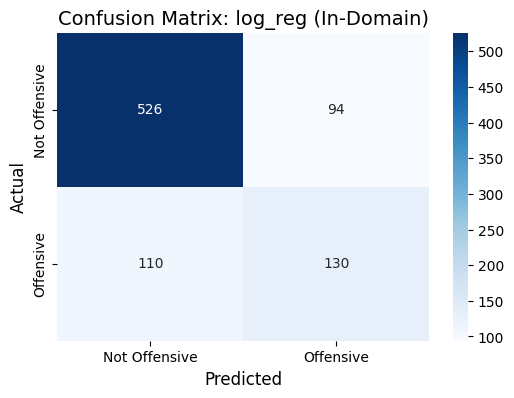


Evaluating random_forest on OLIDv1 test data (In-Domain)...
Accuracy: 0.8012
Classification report for random_forest:
              precision    recall  f1-score   support

           0       0.80      0.96      0.87       620
           1       0.78      0.40      0.53       240

    accuracy                           0.80       860
   macro avg       0.79      0.68      0.70       860
weighted avg       0.80      0.80      0.78       860



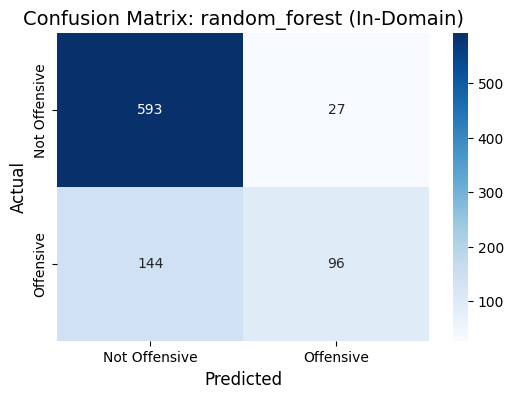


Evaluating gradient_boosting on OLIDv1 test data (In-Domain)...
Accuracy: 0.7965
Classification report for gradient_boosting:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86       620
           1       0.67      0.53      0.59       240

    accuracy                           0.80       860
   macro avg       0.75      0.72      0.73       860
weighted avg       0.79      0.80      0.79       860



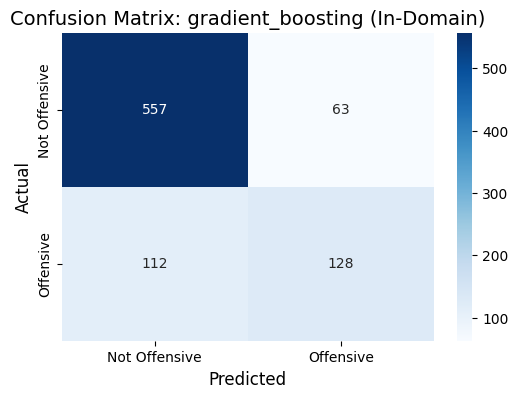


Evaluating sgd on OLIDv1 test data (In-Domain)...
Accuracy: 0.6953
Classification report for sgd:
              precision    recall  f1-score   support

           0       0.78      0.80      0.79       620
           1       0.45      0.42      0.43       240

    accuracy                           0.70       860
   macro avg       0.62      0.61      0.61       860
weighted avg       0.69      0.70      0.69       860



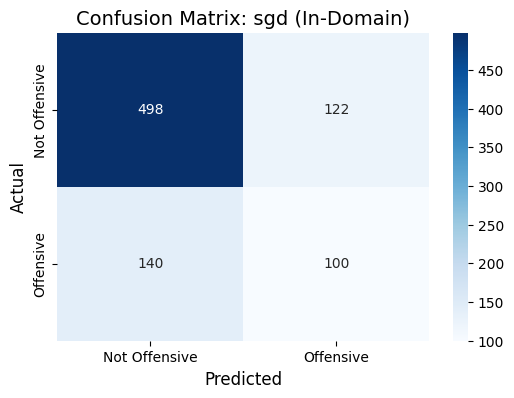


Evaluating mlp on OLIDv1 test data (In-Domain)...
Accuracy: 0.7058
Classification report for mlp:
              precision    recall  f1-score   support

           0       0.83      0.75      0.79       620
           1       0.48      0.60      0.53       240

    accuracy                           0.71       860
   macro avg       0.65      0.67      0.66       860
weighted avg       0.73      0.71      0.72       860



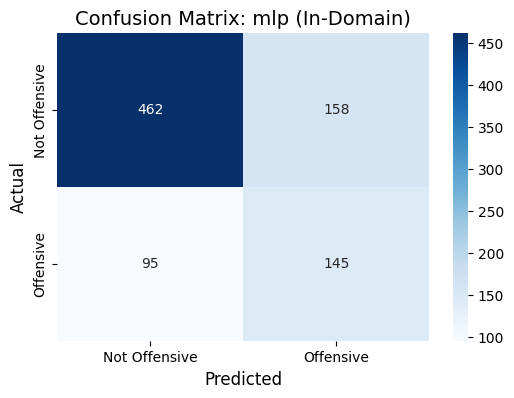


Evaluating lightgbm on OLIDv1 test data (In-Domain)...
Accuracy: 0.7651
Classification report for lightgbm:
              precision    recall  f1-score   support

           0       0.80      0.90      0.85       620
           1       0.62      0.41      0.49       240

    accuracy                           0.77       860
   macro avg       0.71      0.66      0.67       860
weighted avg       0.75      0.77      0.75       860



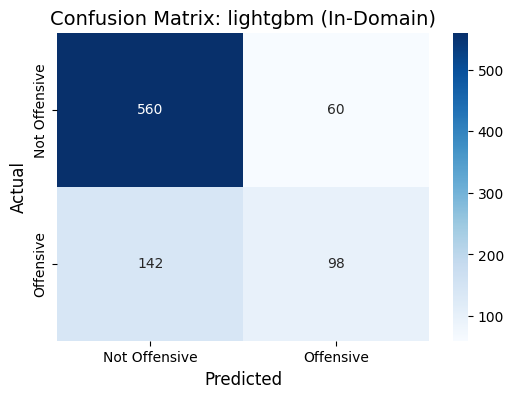


Running Cross-Domain Experiment (Train on HASOC and Test on OLIDv1)

Starting Grid Search for log_reg...
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Best parameters for log_reg: {'clf__C': 10, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
Grid search completed in 0:00:33.426902

Starting Grid Search for random_forest...
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Best parameters for random_forest: {'clf__max_depth': None, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 5, 'clf__n_estimators': 50}
Grid search completed in 0:00:07.015906

Starting Grid Search for gradient_boosting...
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Best parameters for gradient_boosting: {'clf__learning_rate': 0.2, 'clf__max_depth': 10, 'clf__n_estimators': 100}
Grid search completed in 0:01:08.834444

Starting Grid Search for sgd...
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Best parameters for sgd: {'clf__alpha': 0.0001, 'clf__eta0': 0.1

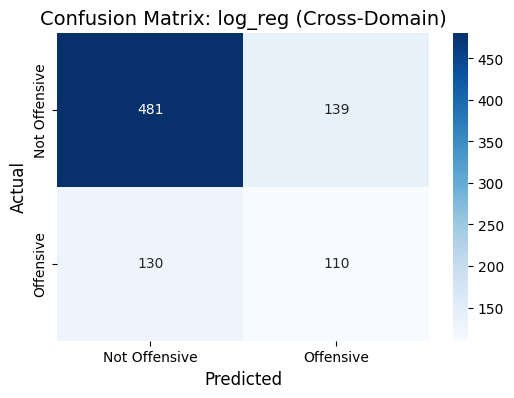


Evaluating random_forest on OLIDv1 test data (Cross-Domain)...
Accuracy: 0.7407
Classification report for random_forest:
              precision    recall  f1-score   support

           0       0.77      0.91      0.84       620
           1       0.57      0.30      0.39       240

    accuracy                           0.74       860
   macro avg       0.67      0.61      0.61       860
weighted avg       0.71      0.74      0.71       860



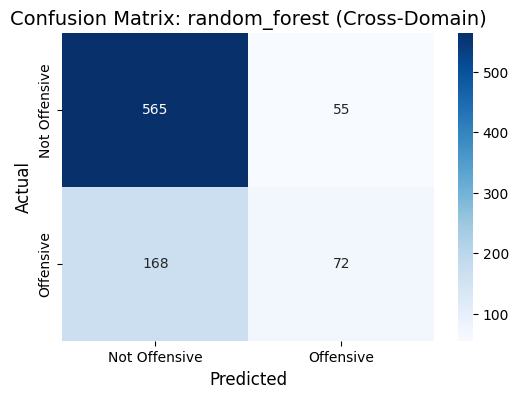


Evaluating gradient_boosting on OLIDv1 test data (Cross-Domain)...
Accuracy: 0.7047
Classification report for gradient_boosting:
              precision    recall  f1-score   support

           0       0.78      0.83      0.80       620
           1       0.46      0.38      0.42       240

    accuracy                           0.70       860
   macro avg       0.62      0.60      0.61       860
weighted avg       0.69      0.70      0.69       860



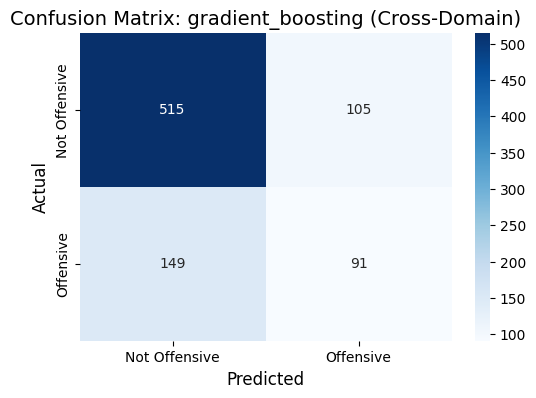


Evaluating sgd on OLIDv1 test data (Cross-Domain)...
Accuracy: 0.4709
Classification report for sgd:
              precision    recall  f1-score   support

           0       0.77      0.38      0.51       620
           1       0.30      0.70      0.42       240

    accuracy                           0.47       860
   macro avg       0.53      0.54      0.47       860
weighted avg       0.64      0.47      0.49       860



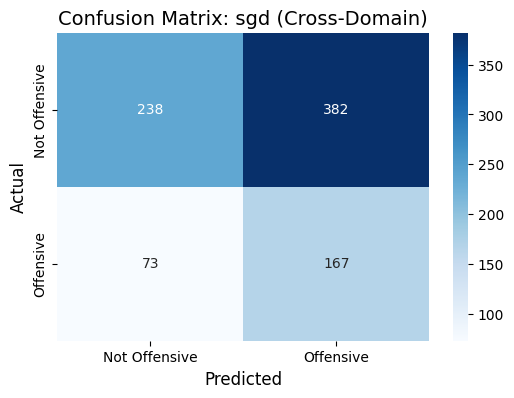


Evaluating mlp on OLIDv1 test data (Cross-Domain)...
Accuracy: 0.6605
Classification report for mlp:
              precision    recall  f1-score   support

           0       0.77      0.75      0.76       620
           1       0.40      0.42      0.41       240

    accuracy                           0.66       860
   macro avg       0.58      0.59      0.59       860
weighted avg       0.67      0.66      0.66       860



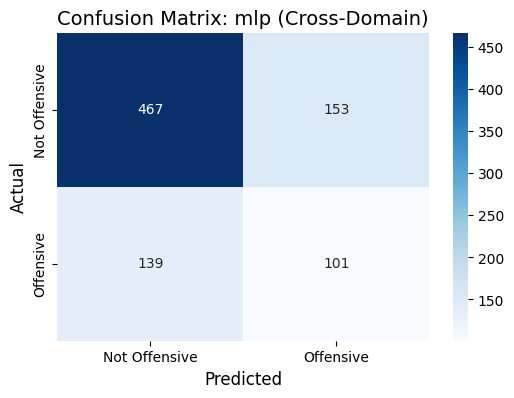


Evaluating lightgbm on OLIDv1 test data (Cross-Domain)...
Accuracy: 0.6814
Classification report for lightgbm:
              precision    recall  f1-score   support

           0       0.78      0.78      0.78       620
           1       0.43      0.43      0.43       240

    accuracy                           0.68       860
   macro avg       0.60      0.61      0.61       860
weighted avg       0.68      0.68      0.68       860



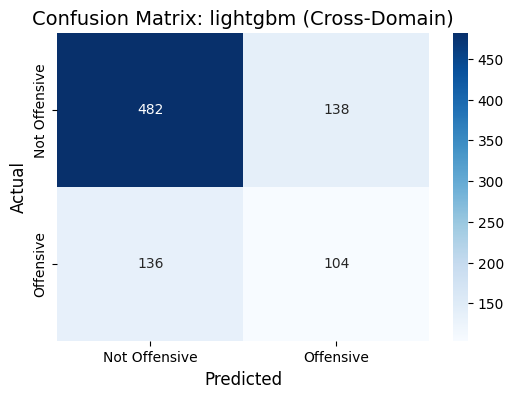

In [ ]:
# RERUN WITH BEST PARAMETERS

best_params = {
    'log_reg': {'clf__C': [10], 'clf__penalty': ['l2'], 'clf__solver': ['lbfgs']},
    'random_forest': {'clf__max_depth': [None], 'clf__min_samples_leaf': [2], 'clf__min_samples_split': [5], 'clf__n_estimators': [50]},
    'gradient_boosting': {'clf__learning_rate': [0.2], 'clf__max_depth': [10], 'clf__n_estimators': [100]},
    'sgd': {'clf__alpha': [0.0001], 'clf__eta0': [0.1], 'clf__learning_rate': ['adaptive'], 'clf__loss': ['hinge'], 'clf__penalty': ['elasticnet']},
    'mlp': {'clf__hidden_layer_sizes': [(100,)], 'clf__activation': ['relu'], 'clf__solver': ['adam'], 'clf__alpha': [0.0001], 'clf__learning_rate': ['adaptive']},
    'lightgbm': {'clf__num_leaves': [50], 'clf__learning_rate': [0.05], 'clf__n_estimators': [100], 'clf__min_child_samples': [30], 'clf__subsample': [0.8], 'clf__colsample_bytree': [0.8]}
}


# Rebuild the pipelines using the best parameters
pipelines = {
    'log_reg': Pipeline([('preprocessor', preprocessor), ('clf', LogisticRegression(max_iter=5000))]),
    'random_forest': Pipeline([('preprocessor', preprocessor), ('clf', RandomForestClassifier())]),
    'gradient_boosting': Pipeline([('preprocessor', preprocessor), ('clf', GradientBoostingClassifier())]),
    'sgd': Pipeline([('preprocessor', preprocessor), ('clf', SGDClassifier(max_iter=1000, tol=1e-3))]),
    'mlp': Pipeline([('preprocessor', preprocessor), ('clf', MLPClassifier(max_iter=1000))]),
    'lightgbm': Pipeline([('preprocessor', preprocessor), ('clf', lgb.LGBMClassifier())])
}

if not hyperparameter_tuning:
  # In-Domain Experiment (Train on OLIDv1 and Test on OLIDv1)
  print("\nRunning In-Domain Experiment (Train on OLIDv1 and Test on OLIDv1)")

  X_train_olid = olid_train[['clean_text', 'text_length', 'special_char_count', 'caps_count', 'avg_word_length', 'unique_words_ratio']]
  y_train_olid = olid_train['labels']
  X_test_olid = olid_test[['clean_text', 'text_length', 'special_char_count', 'caps_count', 'avg_word_length', 'unique_words_ratio']]
  y_test_olid = olid_test['labels']

  best_models_in_domain = {}

  for model_name, pipeline in pipelines.items():
      best_models_in_domain[model_name] = run_grid_search(model_name, pipeline, best_params[model_name], X_train_olid, y_train_olid)

  # Evaluate In-Domain models on OLIDv1 test set
  for model_name, model in best_models_in_domain.items():
      print(f"\nEvaluating {model_name} on OLIDv1 test data (In-Domain)...")
      y_pred = model.predict(X_test_olid)
      print(f"Accuracy: {accuracy_score(y_test_olid, y_pred):.4f}")
      print(f"Classification report for {model_name}:\n{classification_report(y_test_olid, y_pred)}")
      plot_confusion_matrix(y_test_olid, y_pred, model_name, 'In-Domain')

  # Cross-Domain Experiment (Train on HASOC and Test on OLIDv1)
  print("\nRunning Cross-Domain Experiment (Train on HASOC and Test on OLIDv1)")

  X_train_hasoc = hasoc_train[['clean_text', 'text_length', 'special_char_count', 'caps_count', 'avg_word_length', 'unique_words_ratio']]
  y_train_hasoc = hasoc_train['labels']

  best_models_cross_domain = {}

  for model_name, pipeline in pipelines.items():
      best_models_cross_domain[model_name] = run_grid_search(model_name, pipeline, best_params[model_name], X_train_hasoc, y_train_hasoc)

  # Evaluate Cross-Domain models on OLIDv1 test set
  for model_name, model in best_models_cross_domain.items():
      print(f"\nEvaluating {model_name} on OLIDv1 test data (Cross-Domain)...")
      y_pred = model.predict(X_test_olid)
      print(f"Accuracy: {accuracy_score(y_test_olid, y_pred):.4f}")
      print(f"Classification report for {model_name}:\n{classification_report(y_test_olid, y_pred)}")
      plot_confusion_matrix(y_test_olid, y_pred, model_name, 'Cross-Domain')